In [1]:
import pandas as pd
import numpy as np
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
files = [
    '1year.arff',
    '2year.arff',
    '3year.arff',
    '4year.arff',
    '5year.arff'
    ]

df = pd.DataFrame(arff.loadarff(files[0])[0])

for f in files:
    data_temp = arff.loadarff(f)
    df_temp = pd.DataFrame(data_temp[0])
    df = df.merge(df_temp, how='outer')

In [3]:
print(len(df))
df.head(5)

43569


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,b'0'
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,b'0'
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,b'0'
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,b'0'
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,b'0'


# Preprocessing
Look for things like ? instead of NaN, response variable has weird formatting, etc.... This part need not be reported but nice to document for gaining experience. (Add more examples here when they come up)

In [4]:
# Fixing response variable
df['class'] = df['class'].replace([b'0', b'1'], [0, 1])

# Processing
To simulate data science IRL, the test set need to be clean of all wrangling (imputes, normalize, resampling, etc...) and must be left alone until the validation stage (cross_val_score). The common ratio of 80:20 will be used here.

In [5]:
X = df.loc[:, df.columns != 'class'].values
y = df['class'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [6]:
# Fixing response variable
df['class'] = df['class'].replace([b'0', b'1'], [0, 1])

# Impute
X_train = SimpleImputer(strategy="median").fit_transform(X_train)
X_test = SimpleImputer(strategy="median").fit_transform(X_test)

# Normalize the data
X_train = RobustScaler().fit_transform(X_train)
X_test = RobustScaler().fit_transform(X_test)

# Observe class distribution
from collections import Counter
print("Control:   ", Counter(y_train))

Control:    Counter({0: 33180, 1: 1675})


# Random Forest
(SKIP THIS) Set Initial RandomizedSearchCV 

In [7]:
# build a classifier
clf = RandomForestClassifier()

# define cv splitting strategy
# courtesy of Jason Brownlee 
# https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# specify parameters and distributions to sample from
param_dist = {"n_estimators": [1, 2, 3, 4, 5, 7, 10, 12, 13, 14, 15, 17, 20],
              "criterion": ["gini", "entropy", "log_loss"],
              "max_depth": [3, 5, 7, None],
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 5),
              "max_features": sp_randint(1, 11),
              "bootstrap": [True, False],
              'class_weight': ["balanced", "balanced_subsample"]
              }

# run randomized search
n_iter_search = 50

# after n iterations, probability of none of best p  
random_search = RandomizedSearchCV(RandomForestClassifier(), 
                                   param_distributions=param_dist,
                                   cv=cv,
                                   n_iter=n_iter_search,
                                   scoring='roc_auc')

(SKIP THIS) Perform CV 

In [ ]:
result = random_search.fit(X_train, y_train)
print('Best AUC: %s' % result.best_score_)
print('Best Hyperparameters: \n%s' % result.best_params_)

Best AUC: 0.9121211656525634
Best Hyperparameters: 
{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 20}


(START HERE) Fit optimal parameters for each resampling method accordingly 

In [8]:
rf_model = RandomForestClassifier(
        n_estimators=20,
        bootstrap=True,
        criterion="gini",
        max_depth=None,
        max_features=10,
        min_samples_leaf=2,
        min_samples_split=5,
        class_weight="balanced")
    
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_features=10,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=20)

Evaluate Random Forest

In [9]:
from sklearn.model_selection import cross_val_score

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

rf_cv_results = cross_val_score(rf_model, X_test, y_test, scoring="roc_auc", cv = cv)

print("Mean AUC: {0:.3f} \nStd AUC: {1:.3f} ".format(
    rf_cv_results.mean(), rf_cv_results.std()))

Mean AUC: 0.846 
Std AUC: 0.034 


Precision-Recall vs Threshold Curve

(0.0, 1.0)

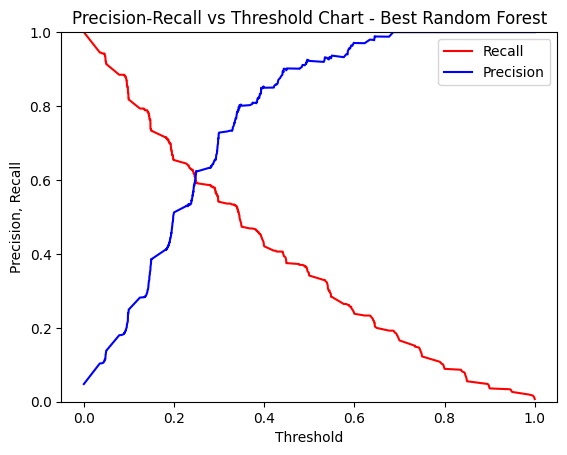

In [10]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
predicted_proba = rf_model.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, predicted_proba[:, 1])

plt.title("Precision-Recall vs Threshold Chart - Best Random Forest")
plt.plot(thresholds, recall[: -1], "r", label="Recall")
plt.plot(thresholds, precision[: -1], "b", label="Precision")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper right")
plt.ylim([0, 1])

Further fine tuning best Random Forest parameters by threshold

In [15]:
threshold = .1

y_preds = (predicted_proba [:,1] >= threshold).astype('int')

print("Classification Report \nThreshold = ", threshold," \nAlgorithm = ", rf_model)
#print(classification_report(y_test, y_preds, digits=4))
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
specificity = tn / (tn+fp)
G_mean = np.sqrt(recall*specificity)
AUC = (recall+specificity)/2
print("Precision: \t", precision.round(3))
print("Recall: \t", recall.round(3))
print("Specificity: \t", specificity.round(3))
print("G-mean: \t", G_mean.round(3))
print("AUC: \t\t", AUC.round(3))

Classification Report 
Threshold =  0.1  
Algorithm =  RandomForestClassifier(class_weight='balanced', max_features=10,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=20)
Precision: 	 0.25
Recall: 	 0.817
Specificity: 	 0.877
G-mean: 	 0.847
AUC: 		 0.847


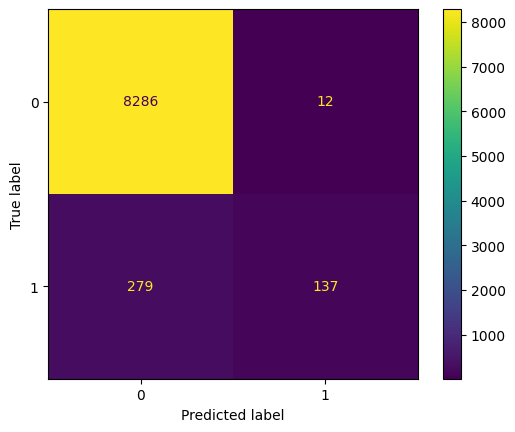

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix test
confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test)

## **Display mean and std AUC for aech of the 5 years for SMOTEENN**


 1year.arff 

Mean AUC: 0.795 
Std  AUC: 0.131 

 2year.arff 

Mean AUC: 0.729 
Std  AUC: 0.101 

 3year.arff 

Mean AUC: 0.804 
Std  AUC: 0.076 

 4year.arff 

Mean AUC: 0.758 
Std  AUC: 0.073 

 5year.arff 

Mean AUC: 0.869 
Std  AUC: 0.054 


# XGBoost

(SKIP THIS) Set Initial xgb.cv() and perform CV 

In [59]:
# CONTROL
dtrain = xgb.DMatrix(X_train, label=y_train)
# dval = xgb.DMatrix(X_test, label=y_test)

# initial parameters
# params = {'eta':0.1, 
#           'max_depth':10, 
#           'subsample':1.0,
#           'min_child_weight':5, 
#           'colsample_bytree':0.2,
#           'colsample_bylevel':0.2,
#           'colsample_bynode':0.2,
#           'objective':'binary:logistic',
#           'eval_metric':'auc'
#           }
# sequential parameters to tune are: max_depth, subsample,
# min_child_weight, colsample_bytree, 
# colsample_bylevel and colsample_bynode
params = {'eta':0.05, 
          'max_depth':12, 
          'subsample':1.0,
          'min_child_weight':5, 
          'colsample_bytree':0.2,
          'colsample_bylevel':0.6,
          'colsample_bynode':1.0,
          'objective':'binary:logistic',
          'eval_metric':'auc',
          'scale_pos_weight':20
          }

cv_results = xgb.cv(params, dtrain, 
                    num_boost_round=1000000,  # the longer the better
                    folds=cv,
                    verbose_eval=50,          # display rounds of 10, save space
                    early_stopping_rounds=10, 
                    # If early_stopping_rounds = n, 
                    # XGBoost will halt before reaching num_boost_round
                    # if it has gone n rounds without an improvement in metric.
                    seed=42)
best_num_rounds = np.argmax(cv_results["test-auc-mean"])
print("\nBest AUC was ", cv_results["test-auc-mean"][best_num_rounds].round(6), "at round ", best_num_rounds)

[0]	train-auc:0.97612+0.00433	test-auc:0.78506+0.04570
[50]	train-auc:0.99999+0.00001	test-auc:0.90083+0.03888
[100]	train-auc:1.00000+0.00000	test-auc:0.91653+0.03268
[150]	train-auc:1.00000+0.00000	test-auc:0.92237+0.03101
[200]	train-auc:1.00000+0.00000	test-auc:0.92689+0.02979
[250]	train-auc:1.00000+0.00000	test-auc:0.92985+0.02885
[300]	train-auc:1.00000+0.00000	test-auc:0.93158+0.02807
[350]	train-auc:1.00000+0.00000	test-auc:0.93294+0.02751
[400]	train-auc:1.00000+0.00000	test-auc:0.93367+0.02703
[450]	train-auc:1.00000+0.00000	test-auc:0.93438+0.02665
[500]	train-auc:1.00000+0.00000	test-auc:0.93487+0.02624
[512]	train-auc:1.00000+0.00000	test-auc:0.93488+0.02612

Best AUC was  0.934975 at round  503


- 'max_depth':10..Best AUC was  0.895461 at round  241
- 'max_depth':8.....Best AUC was  0.892203 at round  184
- 'max_depth':12...Best AUC was  0.903214 at round  493 <- WINNER
- 'max_depth':12, 'subsample':0.8..Best AUC was  0.896663 at round  366 <- left alone
- 'max_depth':12, 'subsample':1.0, 'min_child_weight':3..Best AUC was  0.895863 at round  246
- 'max_depth':12, 'subsample':1.0, 'min_child_weight':7..Best AUC was  0.892757 at round  183 <- left alone
- 'max_depth':12, 'subsample':1.0, 'min_child_weight':5, 'colsample_bytree':0.4..Best AUC was  0.89906 at round  406
- 'max_depth':12, 'subsample':1.0, 'min_child_weight':5, 'colsample_bytree':0.1..Best AUC was  0.896615 at round  348 <- left alone
- 'max_depth':12, 'subsample':1.0, 'min_child_weight':5, 'colsample_bytree':0.1, 'colsample_bylevel':0.4..Best AUC was  0.902782 at round  559
- 'max_depth':12, 'subsample':1.0, 'min_child_weight':5, 'colsample_bytree':0.1, 'colsample_bylevel':0.6..Best AUC was  0.903521 at round  477 <- WINNER
- 'max_depth':12, 'subsample':1.0, 'min_child_weight':5, 'colsample_bytree':0.1, 'colsample_bylevel':0.8..Best AUC was  0.898558 at round  320
- 'max_depth':12, 'subsample':1.0, 'min_child_weight':5, 'colsample_bytree':0.1, 'colsample_bylevel':0.8, 'colsample_bynode':0.4..Best AUC was  0.916029 at round  313
- 'max_depth':12, 'subsample':1.0, 'min_child_weight':5, 'colsample_bytree':0.1, 'colsample_bylevel':0.8, 'colsample_bynode':0.6..Best AUC was  0.926956 at round  261
- 'max_depth':12, 'subsample':1.0, 'min_child_weight':5, 'colsample_bytree':0.1, 'colsample_bylevel':0.8, 'colsample_bynode':0.8..Best AUC was  0.929673 at round  283
- 'max_depth':12, 'subsample':1.0, 'min_child_weight':5, 'colsample_bytree':0.1, 'colsample_bylevel':0.8, 'colsample_bynode':0.9..Best AUC was  0.932725 at round  283
- 'max_depth':12, 'subsample':1.0, 'min_child_weight':5, 'colsample_bytree':0.1, 'colsample_bylevel':0.8, 'colsample_bynode':1.0..Best AUC was  0.932798 at round  279 <- WINNER
- 'max_depth':12, 'subsample':1.0, 'min_child_weight':5, 'colsample_bytree':0.1, 'colsample_bylevel':0.8, 'colsample_bynode':1.0, 'eta':0.05..Best AUC was  0.934975 at round  503 <- WINNER
- 'max_depth':12, 'subsample':1.0, 'min_child_weight':5, 'colsample_bytree':0.1, 'colsample_bylevel':0.8, 'colsample_bynode':1.0, 'eta':0.02..Best AUC was  0.934697 at round  938
- 'max_depth':12, 'subsample':1.0, 'min_child_weight':5, 'colsample_bytree':0.1, 'colsample_bylevel':0.8, 'colsample_bynode':1.0, 'eta':0.07..Best AUC was  0.931931 at round  270
- 'max_depth':12, 'subsample':1.0, 'min_child_weight':5, 'colsample_bytree':0.1, 'colsample_bylevel':0.8, 'colsample_bynode':1.0, 'eta':0.04..Best AUC was  0.934198 at round  496
- 'max_depth':12, 'subsample':1.0, 'min_child_weight':5, 'colsample_bytree':0.1, 'colsample_bylevel':0.8, 'colsample_bynode':1.0, 'eta':0.03..Best AUC was  0.934407 at round  651

In [61]:
# retrain the model on the full training set using the best number of rounds
xgb_model = XGBClassifier(subsample=1.0,
                          max_depth=12,
                          min_child_weight=5,
                          colsample_bytree=0.1,
                          colsample_bylevel=0.8,
                          colsample_bynode=1.0,
                          eta=0.05,
                          eval_metric='auc',
                          objective='binary:logistic',
                          n_estimators=1000,
                          verbosity=1) #,
                          #early_stopping_rounds=10)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.8, colsample_bynode=1.0, colsample_bytree=0.1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.05,
              eval_metric='auc', feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

Evaluate XGBoost

In [62]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

xgb_cv_results = cross_val_score(xgb_model, X_test, y_test, scoring="roc_auc", cv = cv)
print("Mean AUC: {0:.3f} \nStd AUC: {1:.3f}".format(
    xgb_cv_results.mean(), xgb_cv_results.std()))

Mean AUC: 0.925 
Std AUC: 0.033


Precision-Recall vs Threshold

(0.0, 1.0)

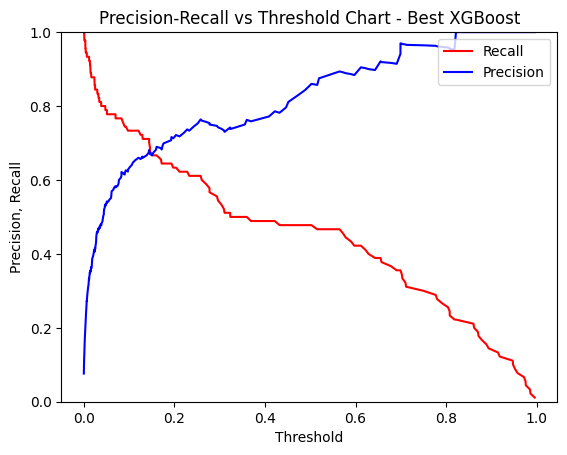

In [66]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
predicted_proba = xgb_model.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, predicted_proba[:, 1])

plt.title("Precision-Recall vs Threshold Chart - Best XGBoost")
plt.plot(thresholds, recall[: -1], "r", label="Recall")
plt.plot(thresholds, precision[: -1], "b", label="Precision")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper right")
plt.ylim([0, 1])

Adjust Threshold

In [73]:
threshold = .07

y_preds = (predicted_proba [:,1] >= threshold).astype('int')

print("Classification Report \nThreshold = ", threshold," \nAlgorithm = ", rf_model)
#print(classification_report(y_test, y_preds, digits=4))
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
specificity = tn / (tn+fp)
G_mean = np.sqrt(recall*specificity)
AUC = (recall+specificity)/2
print("Precision: \t", precision.round(3))
print("Recall: \t", recall.round(3))
print("Specificity: \t", specificity.round(3))
print("G-mean: \t", G_mean.round(3))
print("AUC: \t\t", AUC.round(3))

Classification Report 
Threshold =  0.07  
Algorithm =  RandomForestClassifier(class_weight='balanced', max_features=10,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=20)
Precision: 	 0.58
Recall: 	 0.767
Specificity: 	 0.954
G-mean: 	 0.855
AUC: 		 0.86


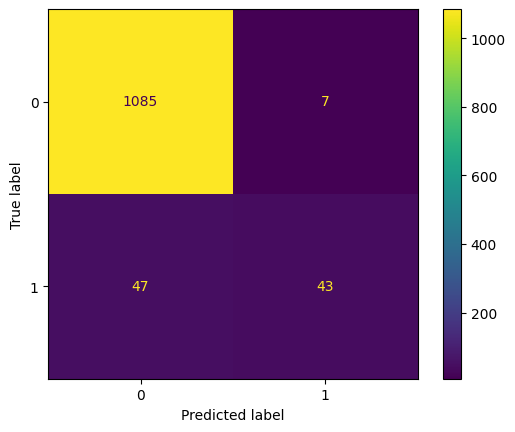

In [74]:
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix test
confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test)

## **Display mean and std AUC for aech of the 5 years for SMOTEENN**

In [79]:
files = [
    '1year.arff',
    '2year.arff',
    '3year.arff',
    '4year.arff',
    '5year.arff'
    ]

df = pd.DataFrame(arff.loadarff(files[0])[0])

for f in files:
    data_temp = arff.loadarff(f)
    df = pd.DataFrame(data_temp[0])
    #df = df.merge(df_temp, how='outer')

    # Fixing response variable
    df['class'] = df['class'].replace([b'0', b'1'], [0, 1])
    X = df.loc[:, df.columns != 'class'].values
    y = df['class'].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    # Fixing response variable
    df['class'] = df['class'].replace([b'0', b'1'], [0, 1])

    # Impute
    X_train = SimpleImputer(strategy="median").fit_transform(X_train)
    X_test = SimpleImputer(strategy="median").fit_transform(X_test)

    # Normalize the data
    X_train = RobustScaler().fit_transform(X_train)
    X_test = RobustScaler().fit_transform(X_test)

    rf_model = RandomForestClassifier(
        n_estimators=20,
        bootstrap=True,
        criterion="gini",
        max_depth=None,
        max_features=10,
        min_samples_leaf=2,
        min_samples_split=5,
        class_weight="balanced")
    rf_model.fit(X_train, y_train)

    xgb_model = XGBClassifier(subsample=1.0,
                          max_depth=12,
                          min_child_weight=5,
                          colsample_bytree=0.1,
                          colsample_bylevel=0.8,
                          colsample_bynode=1.0,
                          eta=0.05,
                          eval_metric='auc',
                          objective='binary:logistic',
                          n_estimators=1000,
                          verbosity=1) 
    xgb_model.fit(X_train, y_train)

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    rf_cv_results = cross_val_score(rf_model, X_test, y_test, scoring="roc_auc", cv = cv)
    print("\n", f, "\n")
    print("RandomForest \nMean AUC: {0:.3f} \nStd  AUC: {1:.3f} ".format(
        rf_cv_results.mean(), rf_cv_results.std()))
    
    xgb_cv_results = cross_val_score(xgb_model, X_test, y_test, scoring="roc_auc", cv = cv)
    print("XGBoost \nMean AUC: {0:.3f} \nStd  AUC: {1:.3f}".format(
    xgb_cv_results.mean(), xgb_cv_results.std()))


 1year.arff 

RandomForest 
Mean AUC: 0.798 
Std  AUC: 0.109 
XGBoost 
Mean AUC: 0.859 
Std  AUC: 0.094

 2year.arff 

RandomForest 
Mean AUC: 0.743 
Std  AUC: 0.091 
XGBoost 
Mean AUC: 0.821 
Std  AUC: 0.067

 3year.arff 

RandomForest 
Mean AUC: 0.788 
Std  AUC: 0.065 
XGBoost 
Mean AUC: 0.859 
Std  AUC: 0.065

 4year.arff 

RandomForest 
Mean AUC: 0.765 
Std  AUC: 0.069 
XGBoost 
Mean AUC: 0.835 
Std  AUC: 0.067

 5year.arff 

RandomForest 
Mean AUC: 0.883 
Std  AUC: 0.060 
XGBoost 
Mean AUC: 0.925 
Std  AUC: 0.033
